# Ciffer Detection Convolutional Neural Network

## Creating generators for training and validation data

In this section, we create two image data generators. The training generator takes an image and applies some simple augmentation by the defined transformations in test_datagen(implementation in next section). We implemented some simple zooming, shifting, and rotation. This helps us to get a lot of unique images out of a small dataset of images. Below we provided some generated samples to make clear what the data augmentation does. In addition, we have a test image data generator. This generator simply takes the image and rescales by 1./255. When we validate or test the network we don't want to manipulate real world data.

After the generators have been created we serve them images from our directory ../images/ciffer/train and ../images/ciffer/validation. Every subfolder in this directory will be transformed to a feature. Because this network uses a category classifier we can use as much subfolders as we want. In our case we define 6 final features. These features are the ciffers I, II, III, IV, V and empty. The empty feature is important to recognise false images.

### Image generators

In [1]:
%matplotlib inline 
from keras.preprocessing.image import ImageDataGenerator, array_to_img

batch_size = 64
image_height = 128
image_width = 128

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        zoom_range=0.1,
        horizontal_flip=False,
        samplewise_center=False,
        samplewise_std_normalization=False,)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255, samplewise_center=False,
        samplewise_std_normalization=False,)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../images/train',  # this is the target directory
        target_size=(image_height, image_width),  # all images will be resized
        batch_size=batch_size,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../images/validation',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')


Using TensorFlow backend.


Found 57 images belonging to 5 classes.
Found 5 images belonging to 5 classes.


### Display Augmented images

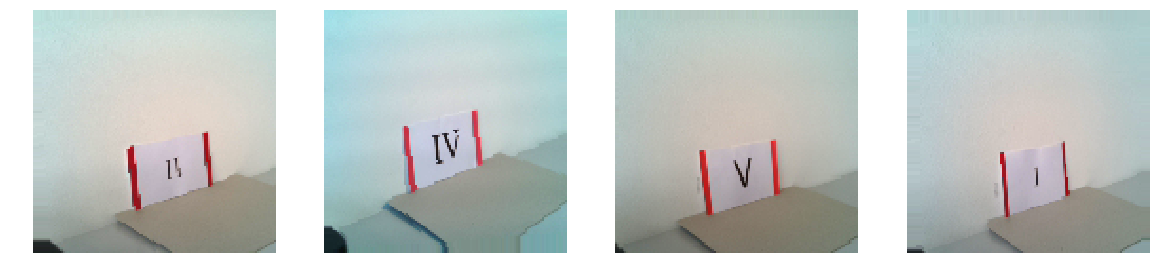

In [2]:
import matplotlib.pyplot as pyplot
for X_batch, y_batch in train_generator:
# grid of 3x3 images
    fig = pyplot.figure(figsize=(20, 10))
    
    n = 4

    for i in range(0, n):
        a=fig.add_subplot(1,n,i+1)

        img = array_to_img(X_batch[i])
        pyplot.imshow(img, cmap=pyplot.get_cmap('gray'))
        pyplot.axis('off')
    pyplot.show()
    break

## Defining our Convolutional Neural Network model

In the next section, we define the layers of our convolutional neural network. The basic of deep learning is stacking a lot of layers on top of each other to create a deep and more robust neural network. We have implemented three convolutional layers with rectifier activation and max pooling. This is a best practice method and used in known nets like VGG16 / VGG19. Afterward, we flatten our filters and add a dense layer(normal neural network layer) with rectifier activation. To prevent our network from overfitting there is a dropout layer and the final dense sigmoid layer to see probability distribution on the possible outcomes. Our model summary shows how many parameters we need for the network. In order to have a good performance on a raspberry pi, we trim the network to the least parameters we could.

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(image_height, image_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten())
model.add(Dense(96, activation='relu', name="fc-1"))
model.add(Dropout(0.5))
model.add(Dense(96, activation='relu', name="fc-2"))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=0, mode='auto')
modelCheckpoint = ModelCheckpoint('../models/ciffer.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=batch_size, write_graph=True)

### Display how many parameters have been used

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 32)      896       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 32)        0         
_________________________________________________________________
block4_conv1 (Conv2D)        (None, 64, 64, 32)        9248      
_________________________________________________________________
block4_pool (MaxPooling2D)   (None, 32, 32, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 64)        18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 64)        36928     
__________

# Train the network

Finally, we feed the data from the generators to our network. Our training procedure contains hundred iterations training and then we validate on real world data that is not used for training. This helps us determine if the network works with images it has not seen before. After training we save our model weights to ../models/ciffer.h5

In [24]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=3,
        validation_data=validation_generator,
        verbose=1,
        validation_steps=10,
        callbacks=[earlyStopping, tensorboard])

Epoch 1/3
100/100 [==============================] - 173s 2s/step - loss: 0.2612 - acc: 0.8981 - val_loss: 0.9503 - val_acc: 0.6000
Epoch 2/3
100/100 [==============================] - 163s 2s/step - loss: 0.1828 - acc: 0.9319 - val_loss: 0.9528 - val_acc: 0.6000
Epoch 3/3
100/100 [==============================] - 164s 2s/step - loss: 0.1150 - acc: 0.9584 - val_loss: 0.8323 - val_acc: 0.6000


### Save our network weights

In [ ]:
model.save_weights('../models/ciffer_128.h5')

In [ ]:
model.load_weights('../models/ciffer_128.h5', by_name=True)

# Test the network

Our network is finally trained and contains all the knowledge to classify new images. In this step, we test the network on its knowledge. All images are new to the network so it can not know them from the past. We make a prediction for every image and will see how good it performs. This is like our final exam to determine if the learning process was successful or not.

In [26]:
test_generator = test_datagen.flow_from_directory(
        '../images/test',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 10 images belonging to 5 classes.


In [27]:
model.evaluate_generator(
        test_generator,
        steps=10)

[0.016836836002767086, 1.0]

This score is really bad, but we only let it train for one epoch. The real model will be trained on dedicated hardware(GPU's) and is out of scope for this document.

In [28]:
predict_generator = test_datagen.flow_from_directory(
        '../images/test',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 10 images belonging to 5 classes.


In [29]:
import numpy as np

In [30]:
print(np.around(model.predict_generator(predict_generator, steps=2), 3))

[[0.998 0.002 0.    0.    0.   ]
 [0.    0.999 0.001 0.    0.   ]
 [0.    0.054 0.    0.    0.946]
 [0.    0.995 0.005 0.    0.   ]
 [0.    0.    1.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.091 0.    0.    0.909]
 [0.    0.    0.    1.    0.   ]
 [0.996 0.004 0.    0.    0.   ]
 [0.    0.005 0.994 0.    0.   ]
 [0.    0.054 0.    0.    0.946]
 [0.    0.    1.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.996 0.004 0.    0.    0.   ]
 [0.    0.091 0.    0.    0.909]
 [0.    0.    0.    1.    0.   ]
 [0.    0.999 0.001 0.    0.   ]
 [0.    0.005 0.994 0.    0.   ]
 [0.    0.995 0.005 0.    0.   ]
 [0.998 0.002 0.    0.    0.   ]]
